# Luminosity dependency of reconstruction error on split 10/90

In [1]:
import getpass
import h5py
import matplotlib
import matplotlib.pyplot as plt
import os
import json
import numpy as np
import pandas as pd
import pickle

from tqdm import tqdm
from sklearn.metrics import roc_auc_score

In [2]:
%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (16, 8)

In [3]:
# Make ROC_curve

from sklearn.metrics import auc, roc_curve, roc_auc_score                          

def get_roc_curve(label, scores, names):
    """Generates ROC Curves for a given array"""
    fig, ax = plt.subplots()
    
    for i in range(len(scores)):
        fpr, tpr, thresholds = roc_curve(label, scores[i])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr,
                 tpr,
                 linewidth=3,
                 #linestyle=line_styles[0],
                 label=("%s AUC: %s" % (names[i], roc_auc)))
        
    plt.legend(frameon=False)
    plt.ylabel("Sensitivity (TPR)")
    plt.xlabel("Fall-out (TNR)")
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.show();

In [4]:
# Get permission to access EOS (Insert your NICE password)

os.system("echo %s | kinit" % getpass.getpass())

········


0

In [5]:
files_dir_01 = "/eos/user/t/tkrzyzek/autoencoder/lumi_dep/split01drop/"
files_dir_08 = "/eos/user/t/tkrzyzek/autoencoder/lumi_dep/split08/"

files_dir = files_dir_01

In [6]:
ae_pred = pickle.load(open(files_dir + "ae_pred.p", "rb"))

In [7]:
ms_scores = pickle.load(open(files_dir + "ms_scores.p", "rb"))
rf_scores = pickle.load(open(files_dir + "rf_scores.p", "rb"))
true_labels = pickle.load(open(files_dir + "true_labels.p", "rb"))
luminosity = pickle.load(open(files_dir + "luminosity.p", "rb"))

In [8]:
X_test = pickle.load(open(files_dir + "x_test.p", "rb"))

In [9]:
true_labels = true_labels[0]
ms_scores = ms_scores[0]
rf_scores = rf_scores[0]

In [10]:
len(X_test[true_labels == 1])

1822

In [11]:
def get_error_df(X_test, predictions, mode="allmean", n_highest = 100):
    
    if mode == "allmean":
        return np.mean(np.power(X_test - predictions, 2), axis=1)
    
    elif mode == "topn":
        temp = np.partition(-np.power(X_test - predictions, 2), n_highest)
        result = -temp[:,:n_highest]
        return np.mean(result, axis=1)
    
    elif mode == "perobj":
        mses = []
        for l in legend:
            mse = np.mean(
                np.power(X_test[:,l["start"]:l["end"]] - predictions[:,l["start"]:l["end"]], 2),
                axis=1)
            mses.append(mse)
     
        return np.maximum.reduce(mses)

In [12]:
ae_scores = get_error_df(X_test, ae_pred, mode="topn")

In [13]:
names = ["Autoencoder", "Mean square", "Random forest"]

In [14]:
inliers = len(X_test[true_labels == 0])
outliers = len(X_test[true_labels == 1])

Good lumis: 145494
Bad lumis: 1822
Ratio of bad lumis: 0.01236797089250319


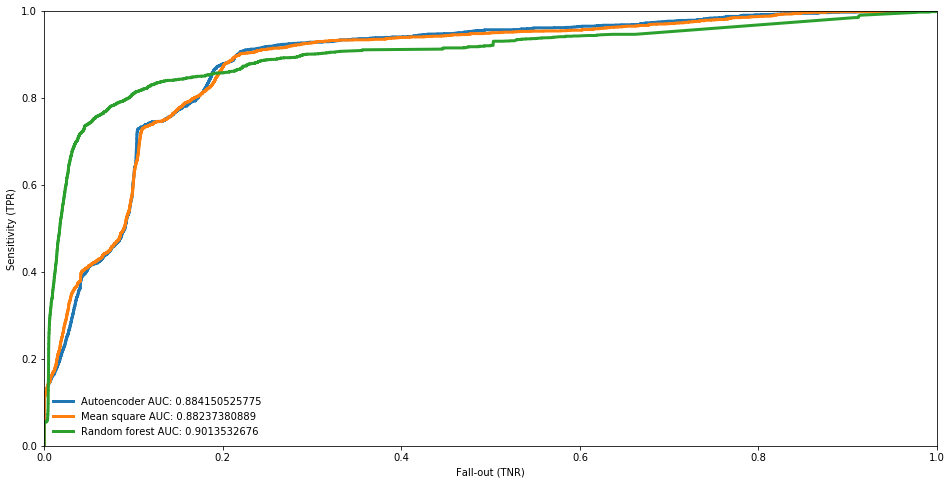

In [15]:
print("Good lumis:", inliers)
print("Bad lumis:", outliers)
print("Ratio of bad lumis:", outliers/len(true_labels))
get_roc_curve(true_labels, [ae_scores, ms_scores, rf_scores], names)

In [31]:
# Index from zero
luminosity = luminosity.reset_index(drop=True)

In [32]:
def print_lumis():
    lumi_df = pd.DataFrame({'luminosity': luminosity,
                           'true_label': true_labels})
    
    print(lumi_df[start:end].to_string())

In [33]:
def pred_vs_feature(y_val, x_val, y_class, y_name="", x_name="", selected=[], linear=False,
                    limit=False):
    '''
    Plots two arbitrary values agains each other.
    '''
    df = pd.DataFrame({'y_val': y_val,
                       'x_val': x_val,
                       'y_class': y_class})

    groups = df.groupby('y_class')
    fig, ax = plt.subplots()

    for name, group in groups:
        ax.plot(group.x_val, 
                group.y_val,
                color="red" if name == 1 else "blue",
                marker='o',
                ms=2,
                linestyle='',
                label= "Anomaly" if name == 1 else "Normal")

    for i in selected:
        ax.plot(x_val[i],
                y_val[i],
                color="green",
                marker='o',
                ms=4,
                linestyle='')
                 
    ax.legend()
    if not linear:
        ax.set_yscale('log')
    if limit:
        plt.xlim([limit[0], limit[1]])
    plt.grid()
    plt.ylabel(y_name)
    plt.xlabel(x_name)
    plt.show()

# Luminosity across time

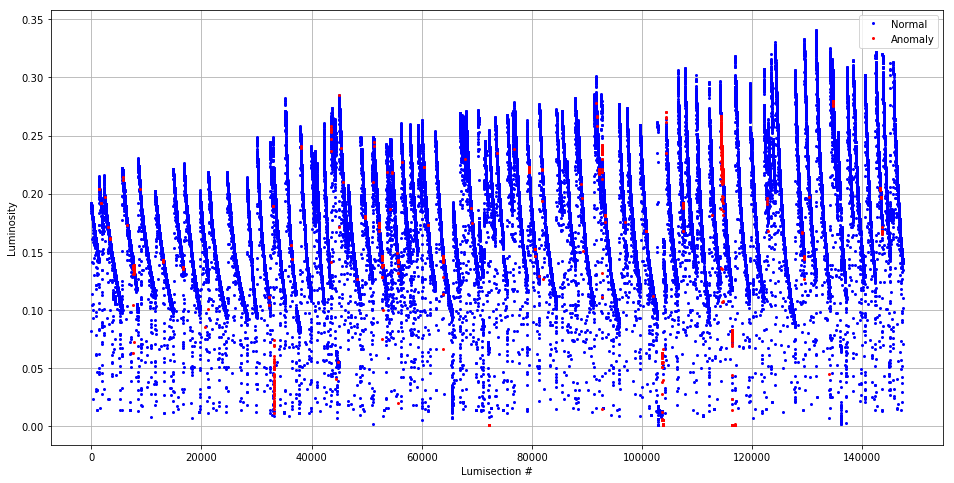

In [34]:
pred_vs_feature(luminosity, range(len(true_labels)), true_labels, "Luminosity", 
                "Lumisection #", linear=True)

# Reconstruction error across time

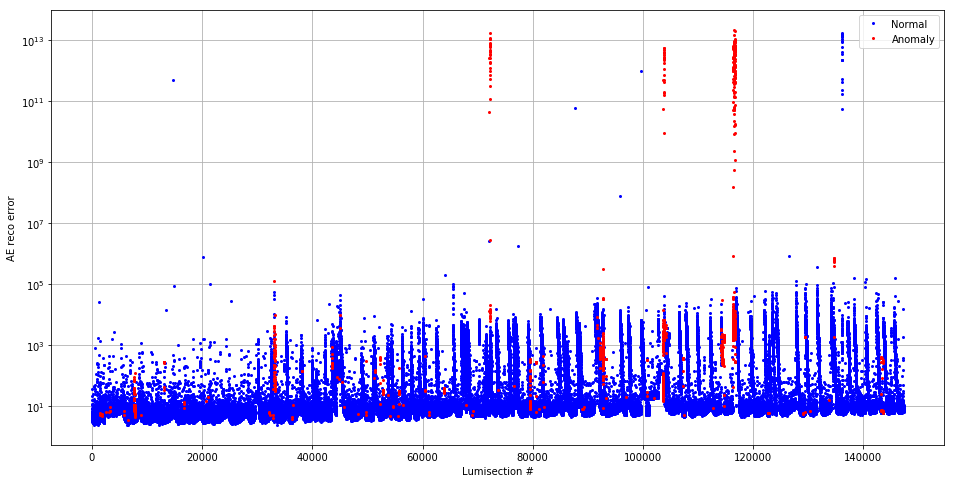

In [35]:
pred_vs_feature(ae_scores, range(len(true_labels)), true_labels, "AE reco error", 
                "Lumisection #")

## Let's try to select lumisections range of the bad lumis cluster. Selected lumisections are marked in green.

In [36]:
begin = 0
end = 0

lumis_range = range(begin, end)

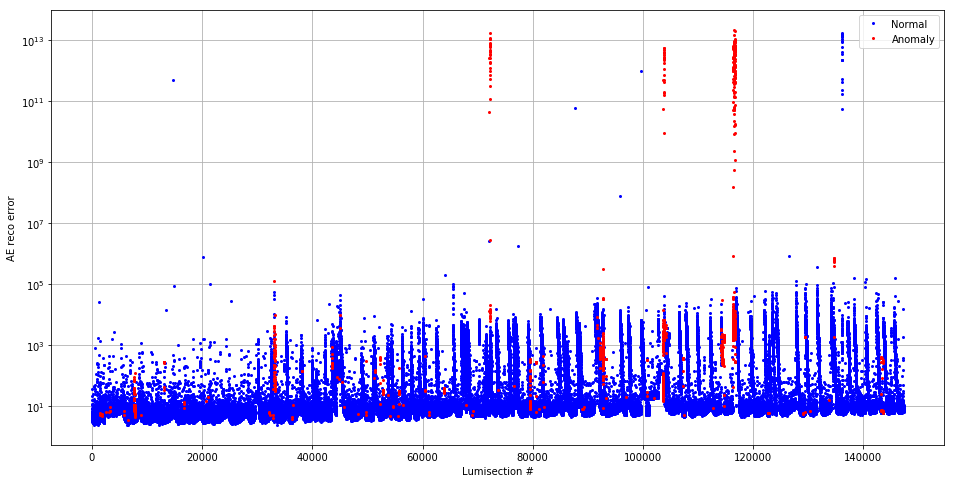

In [37]:
pred_vs_feature(ae_scores, range(len(true_labels)), true_labels, "AE reco error", 
                "Lumisection #", selected=lumis_range)

## Selected lumisections' luminosity (again in green)

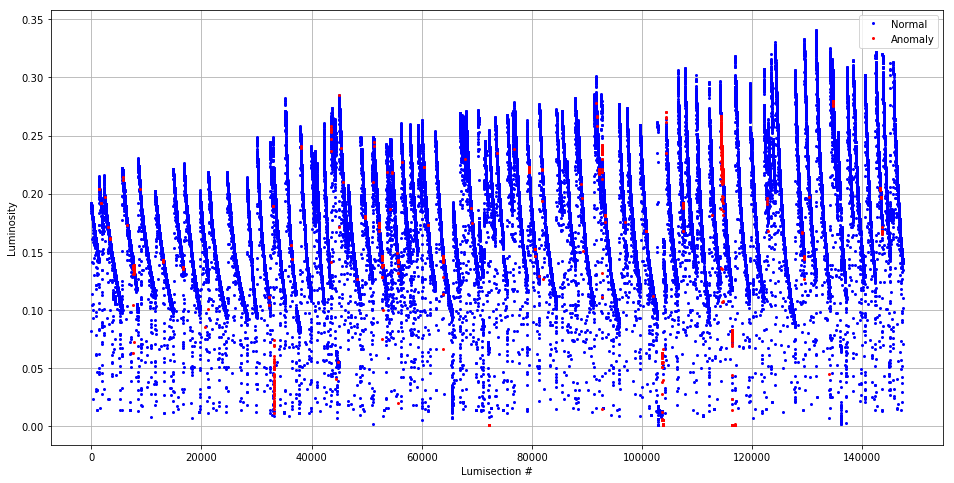

In [38]:
pred_vs_feature(luminosity, range(len(true_labels)), true_labels, "Luminosity", 
                "Lumisection #", linear=True, selected=lumis_range)

## Zoom in to the selected range:

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))


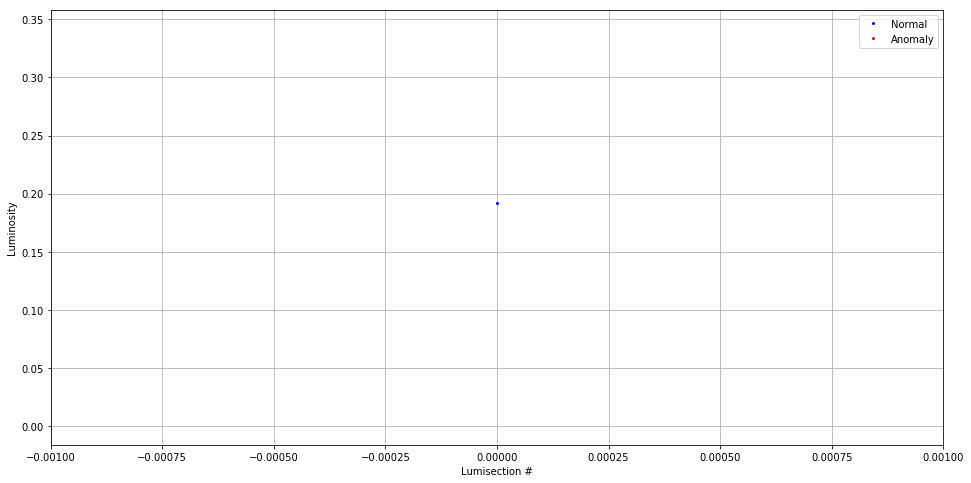

In [39]:
pred_vs_feature(luminosity, range(len(true_labels)), true_labels, "Luminosity", 
                "Lumisection #", linear=True, selected=lumis_range, limit=(begin, end))

# Histogram of luminosity of the selected lumisections

In [ ]:
plt.hist(luminosity[begin:end], bins=np.arange(0, 0.4, 0.05))
plt.show()

# Reconstruction error vs luminosity

## AE reconstruction error vs luminosity 

In [ ]:
pred_vs_feature(ms_scores, luminosity, true_labels, "AE reco error", "Luminosity")

In [ ]:
pred_vs_feature(ae_scores, luminosity, true_labels, "Mean square", "Luminosity")

## ... with the cluster selected above marked in green

In [ ]:
pred_vs_feature(ae_scores, luminosity, true_labels, "AE reco error", "Luminosity",
               lumis_range)

In [ ]:
STEP = 0.05
#SAMPLE_SIZE = 2377
SAMPLE_SIZE=100

features_good = []
features_bad = []

good_mean_mean = []
good_mean_median = []
bad_mean_mean = []
bad_mean_median = []

ae_auc_scores = []
ms_auc_scores = []

def plot_mean_features(X, y):
    
    lower_bounds = np.arange(0, 0.35, STEP)
    X_orig = X
    y_orig = y
    
    for i in lower_bounds:
        print("Luminosity range:", i, "-", i+STEP)
        
        X = pd.DataFrame(X_orig)
        
        X = X[(luminosity >= i) & (luminosity < i+STEP)]
        y = y_orig[(luminosity >= i) & (luminosity < i+STEP)]
        print("Dataset size:", len(X))
        
        X = X.iloc[:, 0:2806]
        X_good = X[y == 0]
        X_bad = X[y == 1]

        print("Good samples:", len(X_good))
        print("Bad samples:", len(X_bad))
            
        sample_good = X_good.sample(SAMPLE_SIZE)        
        good_mean = abs(np.mean(sample_good, axis=0))
        good_median = abs(np.median(sample_good, axis=0))
        
        if len(X_bad) > 0:
            ae_auc = roc_auc_score(y, ae_scores[(luminosity >= i) & (luminosity < i+STEP)])
            ae_auc_scores.append(ae_auc)
            print("AE ROC AUC:", ae_auc)

            ms_auc = roc_auc_score(y, ms_scores[(luminosity >= i) & (luminosity < i+STEP)])
            ms_auc_scores.append(ms_auc)
            print("MS ROC AUC:", ms_auc)
        
            bad_sample = X_bad.sample(SAMPLE_SIZE)
            bad_mean = abs(np.mean(bad_sample, axis=0))
            bad_median = abs(np.median(bad_sample, axis=0))
            bad_mean_mean.append(np.mean(bad_mean))
            bad_mean_median.append(np.mean(bad_median))
        else:
            bad_mean_mean.append(0)
            bad_mean_median.append(0)
            
        good_mean_mean.append(np.mean(good_mean))
        good_mean_median.append(np.mean(good_median))

        fig, (ax1, ax2) = plt.subplots(2, sharex=True)
        
        ax1.plot(np.array([i for i in range(len(bad_mean))]),
                 bad_mean,
                 color="red",
                 linestyle='-',
                 ms=2,
                 marker='o',
                 alpha=0.5,
                 label="Bad")
                 
        ax1.plot(np.array([i for i in range(len(good_mean))]),
                 good_mean,
                 color="b",
                 linestyle='-',
                 ms=2,
                 marker='o',
                 alpha=0.5,
                 label="Good")
        
        ax2.plot(np.array([i for i in range(len(bad_median))]),
                 bad_median,
                 color="red",
                 linestyle='-',
                 ms=2,
                 alpha=0.5,
                 marker='o',
                 label="Bad")
                 
        ax2.plot(np.array([i for i in range(len(good_median))]),
                 good_median,
                 color="b",
                 linestyle='-',
                 alpha=0.5,
                 ms=2,
                 marker='o',
                 label="Good")
        
        ax1.legend()
        ax2.legend()
        ax1.set_ylim(0, 100)
        ax2.set_ylim(0, 100)
        ax1.set_title("Mean")
        ax2.set_title("Median")
        plt.show()

## Plots showing mean and median of each feature across randomly chosen 100 good and 100 bad lumisections (separately) in luminosity ranges

Note: values of test set scaled with parameters from training set!

In [ ]:
matplotlib.rcParams["figure.figsize"] = (16, 8)
plot_mean_features(X_test, true_labels)

In [ ]:
def plot_means():
    matplotlib.rcParams["figure.figsize"] = (15, 10)

    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    ax1.bar(np.arange(0, 0.35, STEP),
           good_mean_mean,
           align='edge',
           width=0.05,
           color='b',
           alpha=0.5,
           label="Good")

    ax1.bar(np.arange(0, 0.35, STEP),
           bad_mean_mean,
           align='edge',
           width=0.05,
           color='r',
           alpha=0.5,
           label="Bad")

    ax1.set_ylabel("Mean mean")
    ax1.set_ylim((0, 5))
    ax1.set_title('Mean mean of lumisections')
    ax1.grid()
    ax1.legend()

    ax2.bar(np.arange(0, 0.35, STEP),
           good_mean_median,
           align='edge',
           width=0.05,
           color='b',
           alpha=0.5,
           label="Good")

    ax2.bar(np.arange(0, 0.35, STEP),
           bad_mean_median,
           align='edge',
           width=0.05,
           color='r',
           alpha=0.5,
           label="Bad")

    ax2.set_ylim((0, 5))
    ax2.set_ylabel("Mean median")
    ax2.set_title('Mean median of lumisections')
    ax2.legend()
    
    plt.xlabel('Luminosity')
    ax2.grid()
    plt.show()

## Mean of above values

In [ ]:
plot_means()

In [ ]:
def plot_ae_vs_ms():
    fig, ax1 = plt.subplots()
    ax1.bar(np.arange(0, 0.3, STEP),
           ae_auc_scores,
           align='edge',
           width=0.02,
           color='b',
           alpha=0.5,
           label="Autoencoder")

    ax1.bar(np.arange(0.02, 0.32, STEP),
           ms_auc_scores,
           align='edge',
           width=0.02,
           color='r',
           alpha=0.5,
           label="Mean square")

    ax1.set_ylabel("ROC AUC")
    ax1.set_ylim((0.4, 1))
    ax1.set_xlim((0, 0.35))
    ax1.set_title('AE vs MS')
    ax1.grid()

    plt.legend()
    plt.xlabel('Luminosity')
    plt.show()    

## Autoencoder vs mean square in luminosity ranges

In [ ]:
matplotlib.rcParams["figure.figsize"] = (15, 10)
plot_ae_vs_ms()